In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import scipy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv("../Data/Umsatzdaten/processed_umsatz.csv")
df["Datum"] = pd.to_datetime(df["Datum"])
df.head(3)

,Gastgewerbe,Umsatz,Datum
0,WZ08-55,92.3,1994-01-01
1,WZ08-551,91.9,1994-01-01
2,WZ08-552,97.3,1994-01-01


In [3]:
umsatz = df[(df["Umsatz"] >= 0) & (df["Gastgewerbe"] == "WZ08-553")].reset_index(drop=True)
umsatz["Jahr"] = umsatz["Datum"].dt.year
durchschnitt_pro_jahr = umsatz.groupby("Jahr")['Umsatz'].mean().reset_index()
umsatz = umsatz.merge(durchschnitt_pro_jahr, on='Jahr', suffixes=('', 'Durchschnitt'))
umsatz.head()

,Gastgewerbe,Umsatz,Datum,Jahr,UmsatzDurchschnitt
0,WZ08-553,68.4,1994-01-01,1994,79.95
1,WZ08-553,52.2,1994-02-01,1994,79.95
2,WZ08-553,81.8,1994-03-01,1994,79.95
3,WZ08-553,119.4,1994-04-01,1994,79.95
4,WZ08-553,99.7,1994-05-01,1994,79.95


In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=umsatz["Datum"], y=umsatz["Umsatz"], name=f'Umsatz'))
fig.add_trace(go.Scatter(x=umsatz["Datum"], y=umsatz["UmsatzDurchschnitt"], name=f'Jahresdurchschnitt'))

# Update layout
fig.update_layout(title="Umsatz Durchschnitt Monat mit Jahres-Trendlinie", xaxis_title="X", yaxis_title="Y")

# Show plot
fig.show()

c:\Users\Ready2Go\AppData\Local\Programs\Python\Python310\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [5]:
umsatz_norm = umsatz.copy()
umsatz_norm["UmsatzNorm"] = (umsatz_norm["Umsatz"] / umsatz_norm["UmsatzDurchschnitt"])
umsatz_norm["Monat"] = umsatz_norm["Datum"].dt.month
fig = px.line(x=umsatz_norm["Monat"], y=umsatz_norm["UmsatzNorm"], color=umsatz_norm["Jahr"])
fig

c:\Users\Ready2Go\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:1985: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Umsatz Varianz Variante 1

In [6]:
umsatz_varianz = umsatz_norm.copy()  # ["UmsatzVarianz"]
# Umsatz - DurchschnittsUmsatzProzentProMonat * UmsatzDurchschnittProJahr
durchschnitt_pro_monat = umsatz_varianz.groupby("Monat")[['UmsatzNorm']].mean().reset_index()
umsatz_varianz = umsatz_varianz.merge(durchschnitt_pro_monat, on='Monat', suffixes=('', 'MonatDurchschnitt'))
umsatz_varianz["UmsatzVarianz"] = umsatz_varianz["Umsatz"] - (umsatz_varianz["UmsatzNormMonatDurchschnitt"] * umsatz_varianz["UmsatzDurchschnitt"])
umsatz_varianz = umsatz_varianz.sort_values(by="Datum")

### Umsatz Varianz Variante 2

In [7]:
umsatz_varianz = umsatz_norm.copy()
# umsatz_varianz.sort_values(by=['Jahr', 'Monat'], inplace=True)

umsatz_varianz = umsatz_varianz.sort_values(by=['Monat', 'Jahr'])

# Step 2: Define rolling window size and apply rolling average for each month
rolling_window_size = 4  # Consider data from current year and 4 preceding years

umsatz_varianz['UmsatzRollingAverage'] = umsatz_varianz.groupby('Monat')['UmsatzNorm'].transform(
    lambda x: x.rolling(window=rolling_window_size, min_periods=1).mean()
)


umsatz_varianz["UmsatzVarianz"] = umsatz_varianz["Umsatz"] - (umsatz_varianz["UmsatzRollingAverage"] * umsatz_varianz["UmsatzDurchschnitt"])
umsatz_varianz = umsatz_varianz.sort_values(by="Datum")

In [8]:
df_uvz = umsatz_varianz.copy()
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_uvz["Datum"], y=df_uvz["Umsatz"], name=f'Tatsächlicher Umsatz'))
fig.add_trace(go.Scatter(
        name='Erwarteter Umsatz',
        x=df_uvz['Datum'],
        y=df_uvz['Umsatz']-df_uvz['UmsatzVarianz'],
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty'
    ))

# Update layout
fig.update_layout(title="Umsatz Abweichung vom Erwarteten Umsatz", xaxis_title="X", yaxis_title="Y")

# Show plot
fig.show()

c:\Users\Ready2Go\AppData\Local\Programs\Python\Python310\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [9]:
weather_data = pd.read_csv("../Data/Wetterdaten_Custom/wea_geo.csv")
weather_data = weather_data[weather_data["Stationsname"] != "Zugspitze"]
weather_data = weather_data[["STATIONS_ID", "MESS_DATUM", "FX", "FM", "RSK", "RSKF", "SDK", "SHK_TAG", "NM", "VPM", "PM", "TMK", "UPM", "TXK", "TNK", "TGK"]]
weather_data["MESS_DATUM"] = pd.to_datetime(weather_data["MESS_DATUM"], format="%Y-%m-%d")
weather_data["Monat"] = weather_data["MESS_DATUM"].dt.month
weather_data["Jahr"] = weather_data["MESS_DATUM"].dt.year
weather_data = weather_data[weather_data["Jahr"] >= 1993]
weather_data = weather_data.drop(columns=["MESS_DATUM", "STATIONS_ID"])
weather_data = weather_data.groupby(['Jahr', 'Monat']).mean().reset_index()
weather_data = weather_data.sort_values(by=["Jahr", "Monat"])
weather_data.head()

,Jahr,Monat,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
0,1993,1,16.187736,5.951887,2.472141,4.475073,2.097097,0.212903,5.115161,6.817595,1007.075269,3.646041,80.375367,6.646921,0.509384,-0.402346
1,1993,2,9.937640,3.523729,0.915909,4.107143,1.871071,0.612100,5.996071,5.580195,1013.431548,0.496104,86.214286,2.926299,-1.806169,-2.682792
2,1993,3,11.068203,3.881944,0.487097,3.038123,4.972903,0.205788,4.447742,6.253959,1008.118817,4.777126,71.815249,9.310264,0.794135,-1.015249
3,1993,4,11.258571,3.852381,1.326970,3.072727,6.212667,0.000000,4.806333,8.782424,999.535000,10.968788,68.366667,15.860606,6.149697,4.244545
4,1993,5,11.017972,3.550230,2.107918,3.536657,7.490645,0.000000,4.549355,11.751320,1001.746237,14.988563,69.249267,20.208504,10.015543,8.445455


In [10]:
umsatz_var_temp = umsatz_varianz.copy()# , "UmsatzNormMonatDurchschnitt"])
umsatz_var_temp = umsatz_var_temp.merge(weather_data, on=['Monat', "Jahr"], suffixes=('', 'Temp'))
umsatz_var_temp["UmsatzVarianzAbs"] = umsatz_var_temp["UmsatzVarianz"].abs()
umsatz_var_temp.head()

umsatz_var_temp = umsatz_var_temp[umsatz_var_temp['Jahr'] >= 2010]
umsatz_var_temp.head()

,Gastgewerbe,Umsatz,Datum,Jahr,UmsatzDurchschnitt,UmsatzNorm,Monat,UmsatzRollingAverage,UmsatzVarianz,FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,UmsatzVarianzAbs
192,WZ08-553,103.4,2010-01-01,2010,103.908333,0.995108,1,1.167782,-17.942293,9.841935,4.153548,1.088587,4.782609,0.757419,8.111842,7.028289,4.467213,1006.409868,-3.030978,87.934426,-1.038065,-5.152258,-6.957419,17.942293
193,WZ08-553,56.1,2010-02-01,2010,103.908333,0.539899,2,0.622190,-8.550679,10.239286,3.989286,1.550595,5.255952,1.370000,11.900000,6.971223,5.449405,995.640000,0.089286,86.339286,2.552143,-2.225714,-3.937857,8.550679
194,WZ08-553,100.4,2010-03-01,2010,103.908333,0.966236,3,1.044261,-8.107425,11.483226,4.152941,1.433871,3.973118,4.007097,0.419355,5.810968,6.993478,1006.247403,5.015591,77.679348,8.796129,1.415484,-0.898065,8.107425
195,WZ08-553,121.2,2010-04-01,2010,103.908333,1.166413,4,1.172745,-0.657934,10.739333,3.956000,0.571023,2.375000,7.378000,0.000000,4.550000,7.676000,1009.705517,9.239548,67.880000,14.021333,4.194667,1.108667,0.657934
196,WZ08-553,112.0,2010-05-01,2010,103.908333,1.077873,5,1.110095,-3.348165,10.366452,4.120645,2.192857,3.681319,4.321935,0.000000,6.204698,9.967039,1003.950676,10.671271,78.022346,14.276129,7.085806,4.950323,3.348165


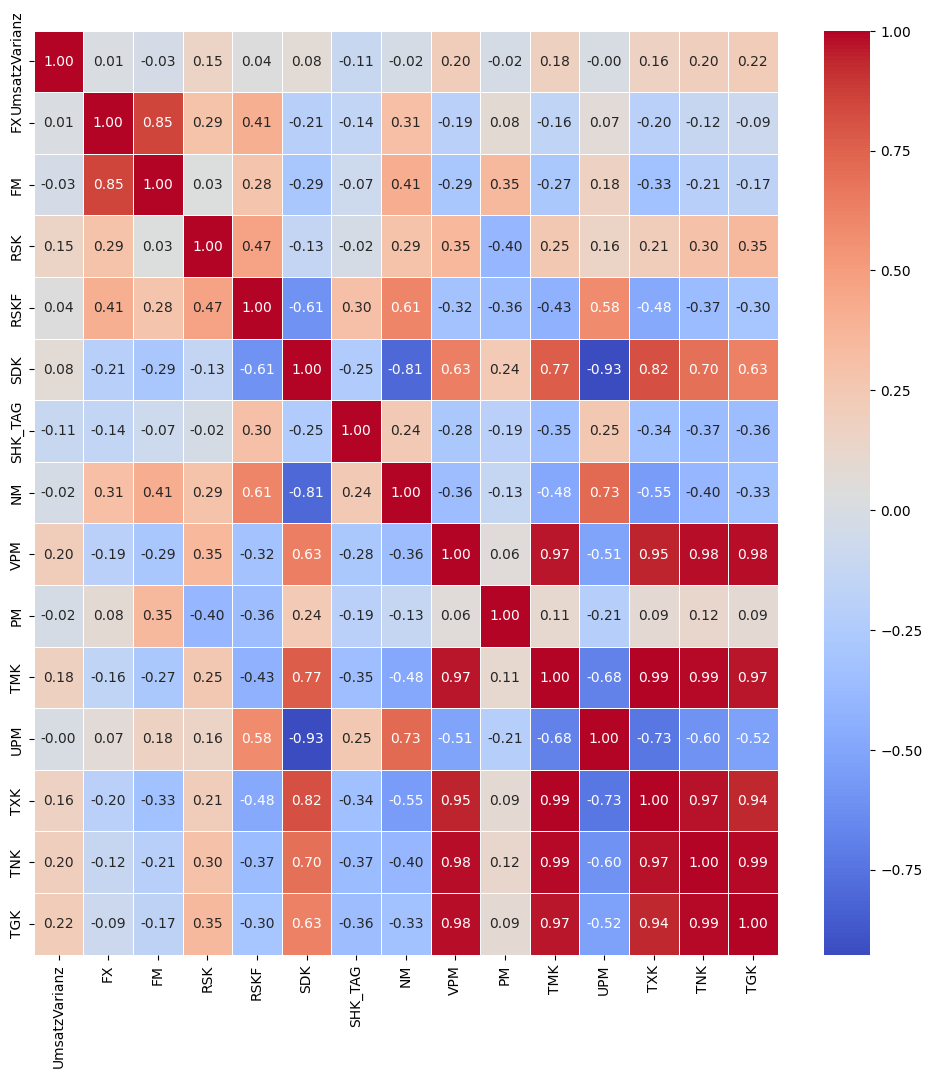

In [11]:
corr = umsatz_var_temp[["UmsatzVarianz",  "FX", "FM", "RSK", "RSKF", "SDK", "SHK_TAG", "NM", "VPM", "PM", "TMK", "UPM", "TXK", "TNK", "TGK"]].corr()

fig = plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5)
plt.show()

In [12]:
sklearn.metrics.mean_squared_error(df_uvz['Umsatz']-df_uvz['UmsatzVarianz'], df_uvz['Umsatz'])

129.07690421673615